# DenseNet
Verilerimizi DenseNet'in 3 versiyonu ile eğiticez.
- DenseNet 121
- DenseNet 201
- DenseNet 169

#### Google Colab Doğrulama

3 tane datasetimiz var. Onlara ulaşabilmek adına doğrulama işlemlerini gerçekleştiriyoruz.


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Bağlanıp bağlanmadığımız görmek amacıyla drive daki çalışma alanımızın içindekileri listele komutunu çalıştırıyoruz.

In [ ]:
ls "/content/drive/My Drive/CT"

checkpoint    denseNet_model_78.h5               my_model_fra.h5  transfer/
covid/        earlystop_model.h5                 non-covid/       works/
COVID/        model.h5                           NonCOVID/
CT_COVID/     model_weights.data-00000-of-00001  Normalize/
CT_NonCOVID/  model_weights.index                saved_models/


#### Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121, MobileNetV2


from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping

Normalize edilmiş değerleri önceki ipynb dosyamızda npy olarak kaydetmiştik. Bu aşama, işlemlerimizi hızlandırmak için yapıldı. numpy kütüphanesinden load() metodunu çağırarak normalize olmuş datamızı kullanmaya başlayabiliriz.

In [ ]:
a= "/content/drive/My Drive/CT/Normalize/"

#300 veri bulunan dataset
l1x=a+ "X_nparray300.npy"
l1y=a+ "y_nparray300.npy"

#1200 veri bulunan dataset
l2x=a+ "X_nparray1200.npy"
l2y=a+ "y_nparray1200.npy"

#3000 veri bulunan dataset
l3x=a+ "X_nparray3000.npy"
l3y=a+ "y_nparray3000.npy"

loaded_array_x1200 = np.load(l2x)
loaded_array_y1200 = np.load(l2y)

In [ ]:
X=loaded_array_x1200
y=loaded_array_y1200

Datamızın doğru yüklendiğine emin olmak için shape metodunu kullanarak inceliyoruz.

In [ ]:
print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

Shape of input data: (2481, 64, 64, 3) and shape of target variable: (2481, 2)


Verisetimiz üzerinde kaç tane forward ve backward propagation yapılacağını ayarladığımız apoch sayımızı 50,100 ve 200 vereceğiz.

Tüm veri kümesini aynı anda sinir ağına veremeyeceğimiz için dataseti parçalara böleriz. Yani batch size olarak adlandırdığımız bu hiperparametre üzerinde çalışılacak bir parti örneğin miktarını bize söyler. Burada 64'er adet image lar halinde modelimize göndereceğiz.

In [ ]:
EPOCHS = 50
# 50, 100, 200
SIZE=64
N_ch=3
BATCH_SIZE = 64
SEED= 42

IMG_W= 64
IMG_H= 64
CHANNELS = 3

INPUT_SHAPE=(IMG_W, IMG_H, CHANNELS)

# DenseNet 121

In [ ]:
def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

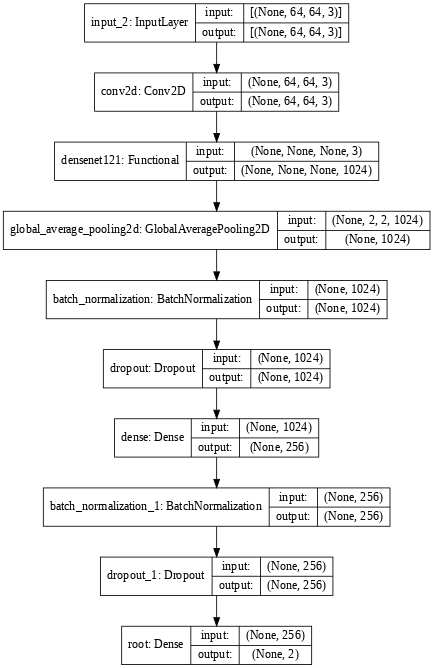

In [ ]:
model=build_densenet121()
# Modelimizi görselleştirelim
from keras.utils import plot_model

plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)



# k-fold

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
31/31 - 23s - loss: 1.1919 - accuracy: 0.5368 - val_loss: 1.0620 - val_accuracy: 0.5272

Epoch 00001: val_loss improved from inf to 1.06198, saving model to model_CNN_kfold.h5
Epoch 2/50
31/31 - 3s - loss: 1.0677 - accuracy: 0.6048 - val_loss: 0.7545 - val_accuracy: 0.5976

Epoch 00002: val_loss improved from 1.06198 to 0.75446, saving model to model_CNN_kfold.h5
Epoch 3/50
31/31 - 3s - loss: 0.8503 - accuracy: 0.6557 - val_loss: 0.9048 - val_accuracy: 0.5654

Epoch 00003: val_loss did not improve from 0.75446
Epoch 4/50
31/31 - 3s - loss: 0.7904 - accuracy: 0.6835 - val_loss: 0.8425 - val_accuracy: 0.6358

Epoch 00004: val_loss did not improve from 0.75446
Epoch 5/50
31/31 - 3s - loss: 0.7458 - accuracy: 0.7051 - val_loss: 1.0302 - val_accuracy: 0.6318

Epoch 00005: val_loss did not improve from 0.75446
Epoch 6/50
31/31 - 3s - loss: 0.6279 - accuracy: 0.7414 - val_loss: 0.9687 - val_accuracy: 0.6620

Epoch 00006: val_loss did not improve from 0.75446
Epoch 7/50
31/31 - 3s -

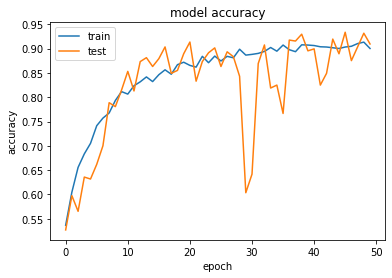

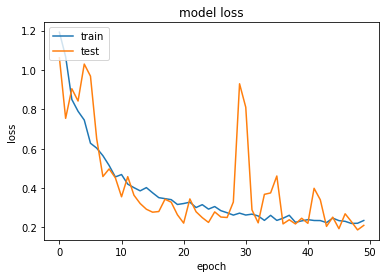

____________________________________________________________________
Epoch 1/50
31/31 - 4s - loss: 0.2428 - accuracy: 0.8972 - val_loss: 0.1646 - val_accuracy: 0.9355

Epoch 00001: val_loss improved from inf to 0.16459, saving model to model_CNN_kfold.h5
Epoch 2/50
31/31 - 4s - loss: 0.2273 - accuracy: 0.9058 - val_loss: 0.1918 - val_accuracy: 0.9294

Epoch 00002: val_loss did not improve from 0.16459
Epoch 3/50
31/31 - 3s - loss: 0.2100 - accuracy: 0.9141 - val_loss: 0.1712 - val_accuracy: 0.9335

Epoch 00003: val_loss did not improve from 0.16459
Epoch 4/50
31/31 - 3s - loss: 0.2353 - accuracy: 0.8985 - val_loss: 0.1884 - val_accuracy: 0.9234

Epoch 00004: val_loss did not improve from 0.16459
Epoch 5/50
31/31 - 3s - loss: 0.2227 - accuracy: 0.9073 - val_loss: 0.1774 - val_accuracy: 0.9274

Epoch 00005: val_loss did not improve from 0.16459
Epoch 6/50
31/31 - 3s - loss: 0.2162 - accuracy: 0.9141 - val_loss: 0.6413 - val_accuracy: 0.6794

Epoch 00006: ReduceLROnPlateau reducing learni

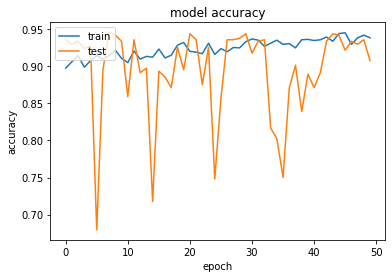

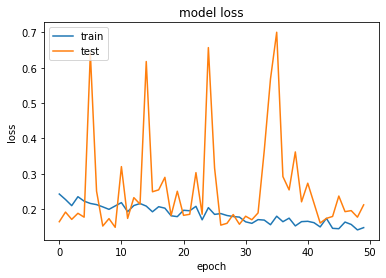

____________________________________________________________________
Epoch 1/50
31/31 - 3s - loss: 0.1695 - accuracy: 0.9302 - val_loss: 0.2173 - val_accuracy: 0.9254

Epoch 00001: val_loss improved from inf to 0.21732, saving model to model_CNN_kfold.h5
Epoch 2/50
31/31 - 3s - loss: 0.1629 - accuracy: 0.9308 - val_loss: 0.5775 - val_accuracy: 0.7782

Epoch 00002: val_loss did not improve from 0.21732
Epoch 3/50
31/31 - 3s - loss: 0.1381 - accuracy: 0.9375 - val_loss: 0.1958 - val_accuracy: 0.9173

Epoch 00003: val_loss improved from 0.21732 to 0.19584, saving model to model_CNN_kfold.h5
Epoch 4/50
31/31 - 3s - loss: 0.1514 - accuracy: 0.9365 - val_loss: 0.0718 - val_accuracy: 0.9698

Epoch 00004: val_loss improved from 0.19584 to 0.07185, saving model to model_CNN_kfold.h5
Epoch 5/50
31/31 - 3s - loss: 0.1510 - accuracy: 0.9370 - val_loss: 0.0790 - val_accuracy: 0.9698

Epoch 00005: val_loss did not improve from 0.07185
Epoch 6/50
31/31 - 3s - loss: 0.1628 - accuracy: 0.9350 - val_los

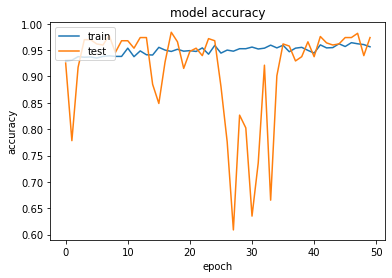

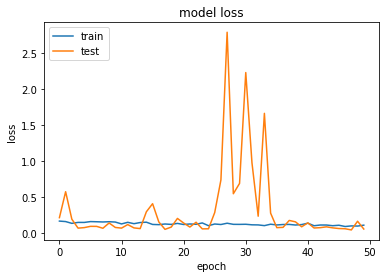

____________________________________________________________________
Epoch 1/50
31/31 - 3s - loss: 0.0932 - accuracy: 0.9636 - val_loss: 0.0922 - val_accuracy: 0.9698

Epoch 00001: val_loss improved from inf to 0.09220, saving model to model_CNN_kfold.h5
Epoch 2/50
31/31 - 3s - loss: 0.0984 - accuracy: 0.9599 - val_loss: 0.0788 - val_accuracy: 0.9738

Epoch 00002: val_loss improved from 0.09220 to 0.07879, saving model to model_CNN_kfold.h5
Epoch 3/50
31/31 - 3s - loss: 0.1084 - accuracy: 0.9604 - val_loss: 0.0661 - val_accuracy: 0.9738

Epoch 00003: val_loss improved from 0.07879 to 0.06612, saving model to model_CNN_kfold.h5
Epoch 4/50
31/31 - 3s - loss: 0.0995 - accuracy: 0.9573 - val_loss: 0.1416 - val_accuracy: 0.9395

Epoch 00004: val_loss did not improve from 0.06612
Epoch 5/50
31/31 - 3s - loss: 0.0871 - accuracy: 0.9636 - val_loss: 0.3459 - val_accuracy: 0.8669

Epoch 00005: val_loss did not improve from 0.06612
Epoch 6/50
31/31 - 3s - loss: 0.0997 - accuracy: 0.9558 - val_los

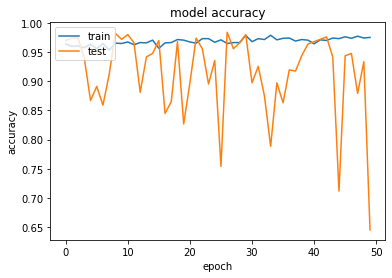

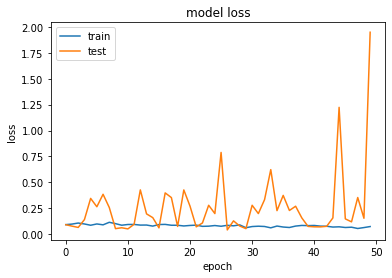

____________________________________________________________________
Epoch 1/50
31/31 - 3s - loss: 0.0813 - accuracy: 0.9698 - val_loss: 0.3392 - val_accuracy: 0.8851

Epoch 00001: val_loss improved from inf to 0.33915, saving model to model_CNN_kfold.h5
Epoch 2/50
31/31 - 3s - loss: 0.0756 - accuracy: 0.9714 - val_loss: 0.4048 - val_accuracy: 0.8508

Epoch 00002: val_loss did not improve from 0.33915
Epoch 3/50
31/31 - 3s - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.4597 - val_accuracy: 0.8226

Epoch 00003: val_loss did not improve from 0.33915
Epoch 4/50
31/31 - 3s - loss: 0.0699 - accuracy: 0.9745 - val_loss: 0.7423 - val_accuracy: 0.7540

Epoch 00004: val_loss did not improve from 0.33915
Epoch 5/50
31/31 - 3s - loss: 0.0626 - accuracy: 0.9719 - val_loss: 0.0959 - val_accuracy: 0.9556

Epoch 00005: val_loss improved from 0.33915 to 0.09591, saving model to model_CNN_kfold.h5
Epoch 6/50
31/31 - 3s - loss: 0.0748 - accuracy: 0.9698 - val_loss: 1.0450 - val_accuracy: 0.6996

Epoch 

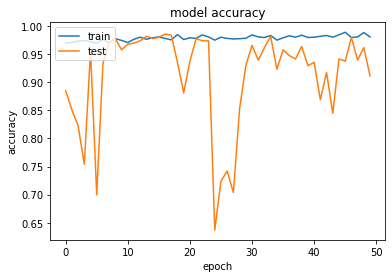

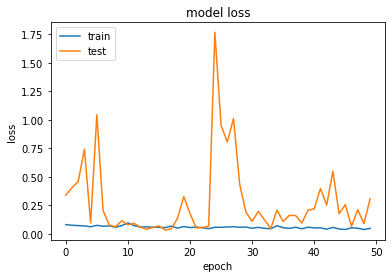

____________________________________________________________________


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error

fprs, tprs, scores = [], [], []
toplamAcc=[]
toplamAccV=[]
toplamLoss=[]
toplamLossV=[]



k = 5
iter = 1 # düzgün gözükmesi için yapıyoruz
# datamızı 5 farklı şekilde bölüyoruz.
cv = KFold(n_splits=k, random_state = 0, shuffle=True)

for train_index, test_index in cv.split(X):
    
    X_train, X_val, y_train, y_val = X[train_index], X[test_index], y[train_index], y[test_index]


    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint('model_CNN_kfold.h5', verbose=1, save_best_only=True)

    datagen.fit(X_train)
    
    # Modeli gerçek zamanlı artırılan datalarla eğitiyoruz.
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                  steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                  epochs=EPOCHS,
                  verbose=2,
                  callbacks=[annealer, checkpoint],
                  validation_data=(X_val, y_val))


    print(f"{iter}. veri kesiti")
    iter += 1


    a=history.history['accuracy'][-1]
    vA=history.history['val_accuracy'][-1]
    l=history.history['loss'][-1]
    vL=history.history['val_loss'][-1]

    toplamAcc.append(a)
    toplamAccV.append(vA)
    toplamLoss.append(l)
    toplamLossV.append(vL)
    
    
    plt.show()
    print(f"training_accuracy  : {a}" )
    print(f"validation_accuracy: {vA}")

    print(f"training_loss:   {l}")
    print(f"validation_loss: {vL}")
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    print('____________________________________________________________________')

# K-cross Validation Sonuçlar




```
__________________________________________1. veri kesiti
training_accuracy  : 0.9002016186714172
validation_accuracy: 0.909456729888916
training_loss:   0.23534385859966278
validation_loss: 0.21052971482276917
__________________________________________2. veri kesiti

training_accuracy  : 0.9380530714988708
validation_accuracy: 0.9072580933570862
training_loss:   0.1478653848171234
validation_loss: 0.21226073801517487
__________________________________________3. veri kesiti

training_accuracy  : 0.9562727808952332
validation_accuracy: 0.9737903475761414
training_loss:   0.11296602338552475
validation_loss: 0.059391625225543976
__________________________________________4. veri kesiti

training_accuracy  : 0.975013017654419
validation_accuracy: 0.6451612710952759
training_loss:   0.0745992511510849
validation_loss: 1.947784423828125

__________________________________________5. veri kesiti

training_accuracy  : 0.980739176273346
validation_accuracy: 0.9112903475761414
training_loss:   0.04825291037559509
validation_loss: 0.307679146528244

```



In [ ]:
def averages():
  print(f"Average training accuracy  : {np.mean(toplamAcc)}" )
  print(f"Average validation accuracy: {np.mean(toplamAccV)}")

  print(f"Average training loss:   {np.mean(toplamLoss)}")
  print(f"Average validation loss: {np.mean(toplamLossV)}")

averages()

Average training accuracy  : 0.9500559329986572
Average validation accuracy: 0.8693913578987121
Average training loss:   0.12380548566579819
Average validation loss: 0.5475291296839714


In [ ]:
print("training acc: %.2f%% (+/- %.3f%%)" % (np.mean(toplamAcc), np.std(toplamAcc)))
print("validati acc: %.2f%% (+/- %.3f%%)" % (np.mean(toplamAccV), np.std(toplamAccV)))
print("training loss: %.2f%% (+/- %.3f%%)" % (np.mean(toplamLoss), np.std(toplamLoss)))
print("validati loss: %.2f%% (+/- %.3f%%)" % (np.mean(toplamLossV), np.std(toplamLossV)))

training acc: 0.95% (+/- 0.029%)
validati acc: 0.87% (+/- 0.115%)
training loss: 0.12% (+/- 0.065%)
validati loss: 0.55% (+/- 0.705%)


## Accuracy ve Loss değerlerinin görselleştirilmeleri

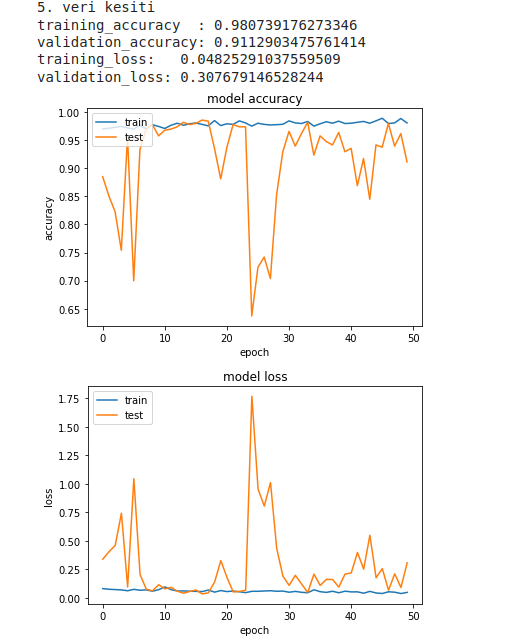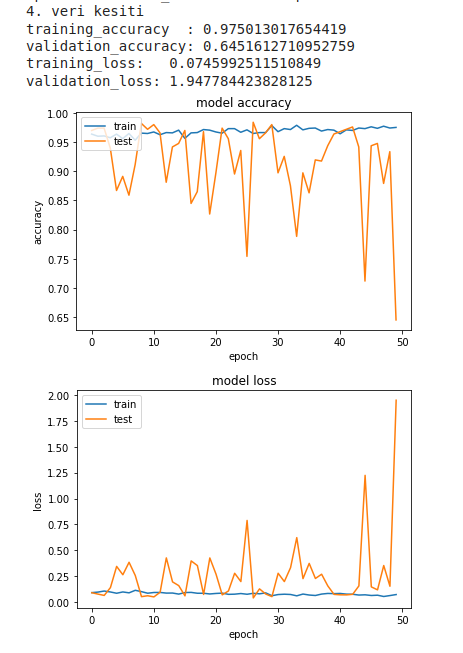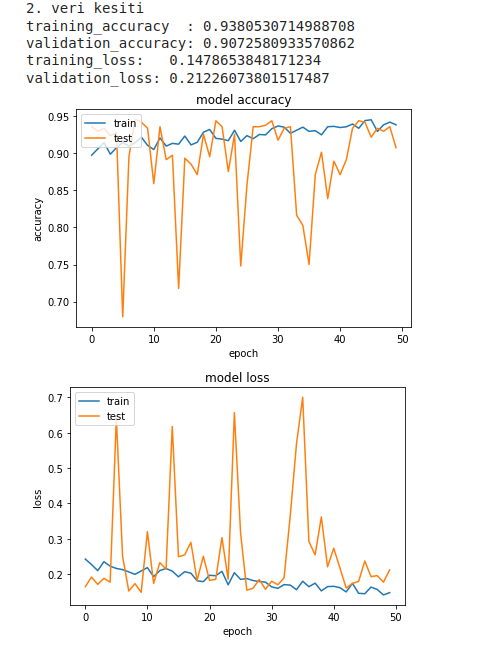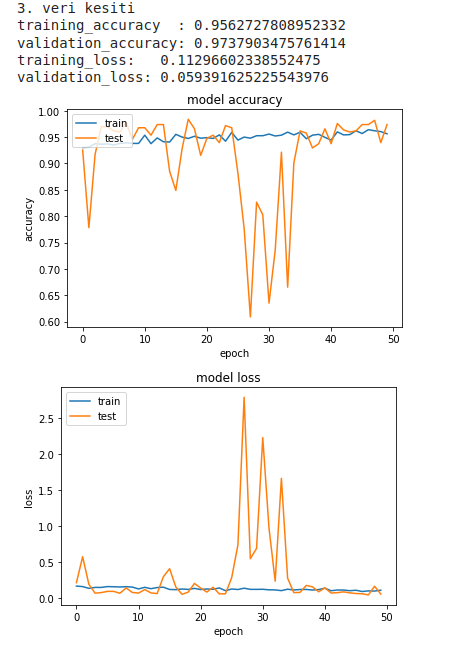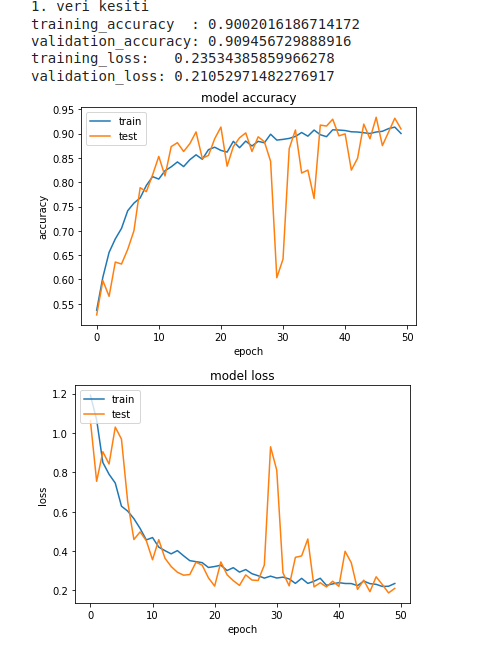

# Sonuçlar

**Accuracy**:
**Precision**: Yanlış Pozitifin maliyetinin ne kadar yüksek olduğunu belirlemek için kullanılır.<br>
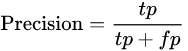 <br>
**Recall**: Pozitif olarak etiketleyerek kaç tane Gerçek Pozitif yakalandığını hesaplar.<br>
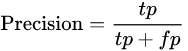<br>

**F1-score**: Hassasiyet(Precision) ve Recall'un ağırlıklı ortalamasıdır.<br>
F1 = 2 × (precision × recall) / (precision + recall)

**Cohen's Kappa**:

**ROC AUC**: ROC eğrisinin altında kalan alan olan AUC tahminler doğrulaştıkça 1 noktasına doğru gitme eğilimindedir.

**R2**:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.911290
Precision: 0.995370
Recall: 0.833333
F1 score: 0.907173
Cohens kappa: 0.823499
ROC AUC: 0.914566
Precision =  0.995
[[237   1]
 [ 43 215]]


### Karmaşıklık Matrisi

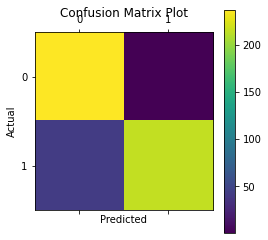

In [ ]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

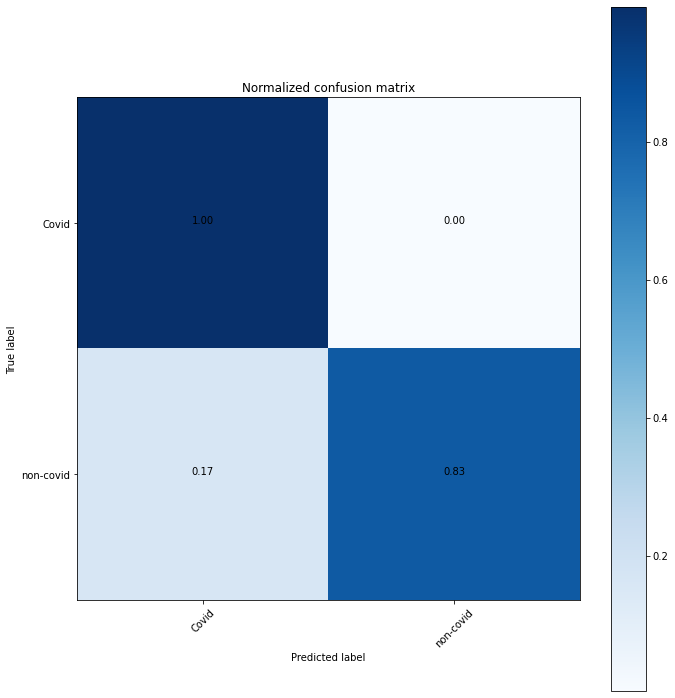

In [ ]:


class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

#### ROC AUC Score

roc_auc_score for Model:  0.9145658263305323


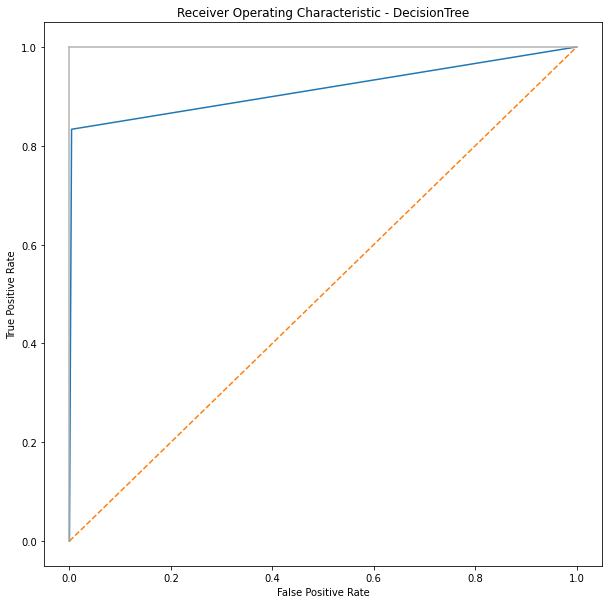

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()